In [6]:
import requests
import matplotlib.pyplot as plt
from IPython.display import Image
import folium
import pickle
import pandas as pd

%matplotlib inline

#conda install -c conda-forge folium

## Usually we'd need a key, endpoint, and list of parameters... but you don't need a key with Socrata API.

In [7]:
#endpoint:
endpoint1 = 'https://data.nashville.gov/resource/fuaa-r5cm.json'

In [8]:
#parameters:
params1 = {'$limit':50000}

### First we want to: Make an API request that returns the entire Top 500 Monthly Searches dataset. Make a chart that shows the number of times "maps" was searched in a month across the entire time frame.

In [9]:
response = requests.get(endpoint1, params = params1)

In [10]:
response.status_code

200

In [11]:
#response.json()

In [12]:
all = response.json()

In [13]:
all = pd.DataFrame(all)

In [14]:
all.head()

,month_name,year,query_count,query_text,month
0,January,2014,223,ebid,NaN
1,January,2014,112,property maps,NaN
2,January,2014,97,maps,NaN
3,January,2014,90,property tax,NaN
4,January,2014,76,jobs,NaN


In [10]:
all.shape

(41177, 5)

In [11]:
all.year.value_counts()

2014    6000
2019    6000
2017    6000
2016    6000
2020    5677
2015    5500
2018    5000
2021    1000
Name: year, dtype: int64

#### Looks good so far... now subset instances where query text contains the word "map".

In [12]:
map_subset = all[all['query_text'].astype(str).str.contains("map|Map|MAp|maP|MAP")].reset_index(drop = True)

In [13]:
map_subset = map_subset[['month_name', 'query_count']]

In [14]:
map_subset.head()

,month_name,query_count
0,January,112
1,January,97
2,January,14
3,January,13
4,January,12


In [15]:
map_subset.shape

(1147, 2)

In [16]:
map_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147 entries, 0 to 1146
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   month_name   1147 non-null   object
 1   query_count  1146 non-null   object
dtypes: object(2)
memory usage: 18.0+ KB


In [17]:
map_subset.dropna(inplace = True)

In [18]:
#convert query_count to numeric type so we can sum
#map_subset.query_count = pd.to_numeric(map_subset.query_count)
map_subset['query_count'] = map_subset.query_count.astype(int)

In [19]:
#check
map_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1146 entries, 0 to 1146
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   month_name   1146 non-null   object
 1   query_count  1146 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 22.4+ KB


#### Group the query counts by month.

#### I'm just going to create a series and plot that - since I'm doing this from a subset the simple counts of the months' occurances correspond with the amount of times "maps" were in the queries.

In [20]:
monthly = map_subset.groupby(['month_name'])['query_count'].apply(lambda x : x.astype(int).sum())

In [21]:
monthly = pd.DataFrame(monthly)

<AxesSubplot:title={'center':'Map Related Searches Per Month Between 2014 & 2021'}, xlabel='Month', ylabel='Search Count'>

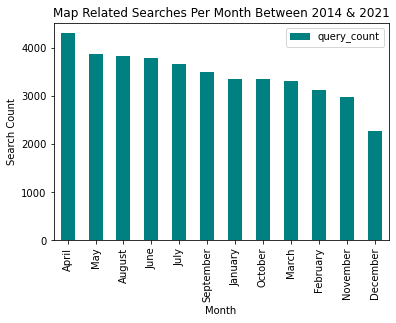

In [22]:
monthly.sort_values(['query_count'], ascending = False).plot(kind = 'bar', 
      title = 'Map Related Searches Per Month Between 2014 & 2021', 
      color = 'teal', 
      xlabel = 'Month', 
      ylabel = 'Search Count')

### Next: Make an API request that returns the months where "fire" was searched in 2016. Which month had the most searches?
#### August

In [23]:
#endpoint:
endpoint2 = 'https://data.nashville.gov/resource/fuaa-r5cm.json'

In [24]:
#parameters:
params2 = {'$limit':50000,
          '$select': 'month_name, query_count',
          '$q': 'fire',
          'year': 2016}

In [25]:
response = requests.get(endpoint2, params = params2)

In [26]:
response.status_code

200

In [27]:
#response.json()

In [28]:
fires_2016 = response.json()
fires_2016 = pd.DataFrame(fires_2016)

In [29]:
fires_2016.head()

,month_name,query_count
0,January,13
1,January,19
2,January,7
3,February,8
4,February,8


In [30]:
fires_2016.dropna(inplace = True)
fires_2016['query_count'] = fires_2016.query_count.astype(int)

In [31]:
fires_monthly = fires_2016.groupby(['month_name'])['query_count'].apply(lambda x : x.astype(int).sum())
fires_monthly = pd.DataFrame(fires_monthly)

<AxesSubplot:title={'center':'Fire Related Searches Per Month Between 2014 & 2021'}, xlabel='Month', ylabel='Search Count'>

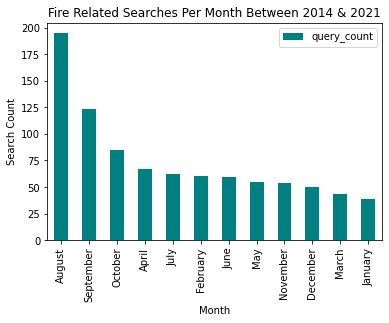

In [32]:
fires_monthly.sort_values(['query_count'], ascending = False).plot(kind = 'bar',
            title = 'Fire Related Searches Per Month Between 2014 & 2021', 
             color = 'teal', 
             xlabel = 'Month', 
             ylabel = 'Search Count')

### Make an API request that returns all the times a query was run more than 100 times in a month. How many times did this occur?
#### 1,061 times

In [33]:
#endpoint:
endpoint3 = 'https://data.nashville.gov/resource/fuaa-r5cm.json'
#parameters:
params3 = {'$select': 'month_name, year, query_count',
          '$group': 'year, month_name, query_count',
          '$having': 'query_count > 100',
          '$limit': 50000}
response = requests.get(endpoint3, params = params3)
response.status_code

200

In [34]:
#response.json()

In [35]:
o_100 = response.json()
o_100 = pd.DataFrame(o_100)

In [36]:
o_100.head()

,month_name,year,query_count
0,January,2021,191
1,April,2019,114
2,August,2015,155
3,December,2019,126
4,April,2017,174


In [37]:
o_100.shape

(1061, 3)

### Make another API request that returns all the times "codes" was searched more than 100 times in a month. How many times did this occur?
#### 53 times

In [38]:
#endpoint:
endpoint4 = 'https://data.nashville.gov/resource/fuaa-r5cm.json'
#parameters:
params4 = {'$select': 'month_name, year, query_count',
          '$group': 'year, month_name, query_count',
          '$having': 'query_count > 100',
           '$q': 'codes',
          '$limit': 50000}
response = requests.get(endpoint4, params = params4)
response.status_code

200

In [39]:
#response.json()

In [40]:
o_100_codes = response.json()
o_100_codes = pd.DataFrame(o_100_codes)

In [41]:
o_100_codes.head()

,month_name,year,query_count
0,August,2015,117
1,September,2015,101
2,April,2016,111
3,August,2016,104
4,February,2016,121


In [42]:
o_100_codes.shape

(53, 3)

### Make an API request to pull back all the data from hubNashville (311) Service Requests (The full data set is too big for a single request so you will need to combine the output from multiple requests). Compare it to the Top 500 Monthly Searches data set. What do you observe? (This is open-ended, there isn't a specific answer for this one)

There are 627,061 results, so with a download limit of 50,000 that's:
rows = 627,061
pages = 13

In [43]:
#endpoint:
endpoint = 'https://data.nashville.gov/resource/7qhx-rexh.json'

In [44]:
#parameters:
params = {'$limit': 630000}
response = requests.get(endpoint, params = params)
response.status_code

200

### Started a for loop but... I guess we don't need one?

full_311 = []
for page in list(range(13)):
    
  for page in list(range(13)):
    offset = str(page * 50000)}
#response1 = requests.get(endpoint, params = params)
#response1.status_code    

In [45]:
#for page in list(range(13)):
   # offset_num = str(page * 50000)

In [46]:
three11 = response.json()
three11 = pd.DataFrame(three11)
three11.shape

(628205, 33)

### Find 2 new data sets on data.nashville.gov, make API requests to pull the data, and do an analysis that combines the data sets.

In [50]:
endpoint = 'https://data.nashville.gov/resource/kqff-rxj8.json'

In [52]:
params = {'$select': 'council_district, permit_subtype_description, mapped_location',
    '$q': 'Commercial', 
    '$limit': 50000}
response = requests.get(endpoint, params = params)
response.status_code

200

In [54]:
commercial = response.json()
commercial = pd.DataFrame(commercial)
print(commercial.shape)
commercial.head()

(749, 3)


,council_district,permit_subtype_description,mapped_location
0,16,Restaurant (Full Service),"{'latitude': '36.114608', 'longitude': '-86.74..."
1,6,Demolition Permit - Commercial,"{'latitude': '36.188583', 'longitude': '-86.74..."
2,21,"Accessory Structure, Carport","{'latitude': '36.161974', 'longitude': '-86.82..."
3,19,"Multifamily, Condominium > 5 Unit Bldg","{'latitude': '36.179374', 'longitude': '-86.78..."
4,33,"General Office, Professional Services","{'latitude': '36.0251', 'longitude': '-86.6159..."


### BONUS: Socrata is used by many cities, states, and federal organizations. Find additional datasets through Socrata's Open Data Network (http://www.opendatanetwork.com/) and do an analysis comparing them to Nashville or each other.